## Impotar librerías

In [45]:
# Load libraries
import os
import datetime
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from sklearn.manifold import TSNE
from statsmodels.tsa.stattools import coint

from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

## Descargar datos

In [2]:
def fetch_yahoo_finance(tickers, period='1d', start='2018-01-01'):
    price_list = []
    for ticker in tickers:
        try:
            prices = yf.download(ticker, start=start)['Close']
            prices = pd.DataFrame(prices)
            prices.columns = [ticker]
            price_list.append(prices)
        except:
            pass
        prices_df = pd.concat(price_list,axis=1)
    prices_df = prices_df.sort_index()
    return prices_df

In [3]:
#scraping wikipedia to fetch S&P 500 stock list
snp500url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
data_table = pd.read_html(snp500url)
tickers = data_table[0][1:]['Symbol'].tolist()
# Cargar datos
sp500_datafile = 'C:/Users/Administrador/Repositorios/ia_for_investments/unsupervised_learning/clustering/sp500data.csv'
if not os.path.exists(sp500_datafile):
    df = fetch_yahoo_finance(tickers)
    df.to_csv(sp500_datafile)
else:
    df = read_csv(sp500_datafile, index_col=0)

## Análisis exploratorio de datos

In [4]:
df.shape

(1681, 502)

In [5]:
df.head()

,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,APD,...,WY,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00,61.529999,58.790001,98.410004,153.839996,177.699997,10.98,10.88,43.985001,67.599998,165.509995,...,35.299999,31.139999,146.990005,164.300003,47.810001,68.070000,81.599998,103.709999,120.446602,71.769997
2018-01-03 00:00:00,61.900002,58.919998,99.949997,154.550003,181.039993,11.55,10.87,44.115002,69.320000,166.410004,...,35.610001,32.000000,149.740005,162.520004,47.490002,68.900002,81.529999,105.769997,121.281555,72.099998
2018-01-04 00:00:00,62.189999,58.820000,99.379997,156.380005,183.220001,12.12,10.83,44.570000,68.800003,167.050003,...,35.320000,32.549999,151.259995,163.399994,47.119999,69.360001,82.360001,107.860001,121.106796,72.529999
2018-01-05 00:00:00,62.990002,58.990002,101.110001,157.669998,185.339996,11.88,10.87,44.865002,69.900002,168.449997,...,35.270000,32.459999,152.229996,164.490005,46.790001,69.230003,82.839996,109.540001,122.310677,73.360001
2018-01-08 00:00:00,63.290001,58.820000,99.489998,158.929993,185.039993,12.28,10.87,44.980000,70.050003,168.630005,...,35.500000,32.580002,151.410004,162.300003,47.139999,69.480003,82.980003,110.629997,122.543686,74.239998


In [6]:
df.describe()

,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,APD,...,WY,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
count,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,...,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000,1681.000000
mean,61.521511,97.767139,118.807930,252.972285,406.744313,77.679072,19.293932,57.451279,109.891100,243.684730,...,31.506758,28.435806,209.010934,106.197603,61.476889,94.571832,111.187388,293.322647,125.519389,149.040155
std,12.652348,19.998652,32.784017,69.476650,128.784514,46.282106,4.793168,15.422022,31.836816,46.904633,...,5.017192,6.158998,35.212142,30.750966,8.402125,21.242169,18.651790,121.053825,15.810677,39.725270
min,34.750000,56.270000,62.980000,133.669998,177.699997,9.530000,9.560000,25.270000,61.130001,148.910004,...,13.470000,9.250000,134.839996,43.020000,42.130001,56.639999,56.520000,103.709999,78.281555,71.510002
25%,50.810001,82.660004,90.480003,184.500000,284.940002,31.719999,15.600000,45.750000,76.169998,217.289993,...,28.540001,23.930000,187.639999,84.959999,55.880001,76.820000,94.559998,204.490005,113.640778,117.919998
50%,61.220001,103.290001,111.860001,264.470001,398.410004,80.779999,18.650000,53.990002,118.330002,251.710007,...,31.660000,27.889999,208.809998,102.360001,63.119999,90.309998,113.820000,268.010010,122.543686,159.690002
75%,69.760002,111.820000,148.470001,311.029999,507.290009,106.970001,23.570000,66.570000,135.000000,283.970001,...,35.060001,32.860001,234.600006,122.300003,68.309998,110.760002,127.709999,332.119995,135.330093,176.690002
max,91.980003,141.460007,197.690002,415.420013,688.369995,211.380005,29.270000,110.489998,179.279999,325.250000,...,42.570000,45.770000,294.380005,201.509995,77.410004,145.949997,143.190002,614.549988,173.407761,247.029999


## Preparación de datos

In [7]:
# Limpieza de datos
if df.isnull().values.any():
    missing_fractions = df.isnull().mean().sort_values(ascending=False)
    drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
    df = df.drop(labels=drop_list, axis=1)
    df = df.ffill()
df.shape

(1681, 490)

In [8]:
# Extraer las características para clusterización
data = pd.DataFrame(np.log(df / df.shift(1)).mean() * 252, columns=['Returns'])
data['Volatility'] = np.log(df / df.shift(1)).std() * np.sqrt(252)
# Poner todo en la misma escala
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

## Evaluación de modelos y algoritmos

### K-Means

In [9]:
# Encontrar el número óptimo de clústers (Elbow Method y Silhoutte_score)
distorsions = []
silhouette = []
max_loop = 20
for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)
    silhouette.append(metrics.silhouette_score(X, kmeans.labels_))

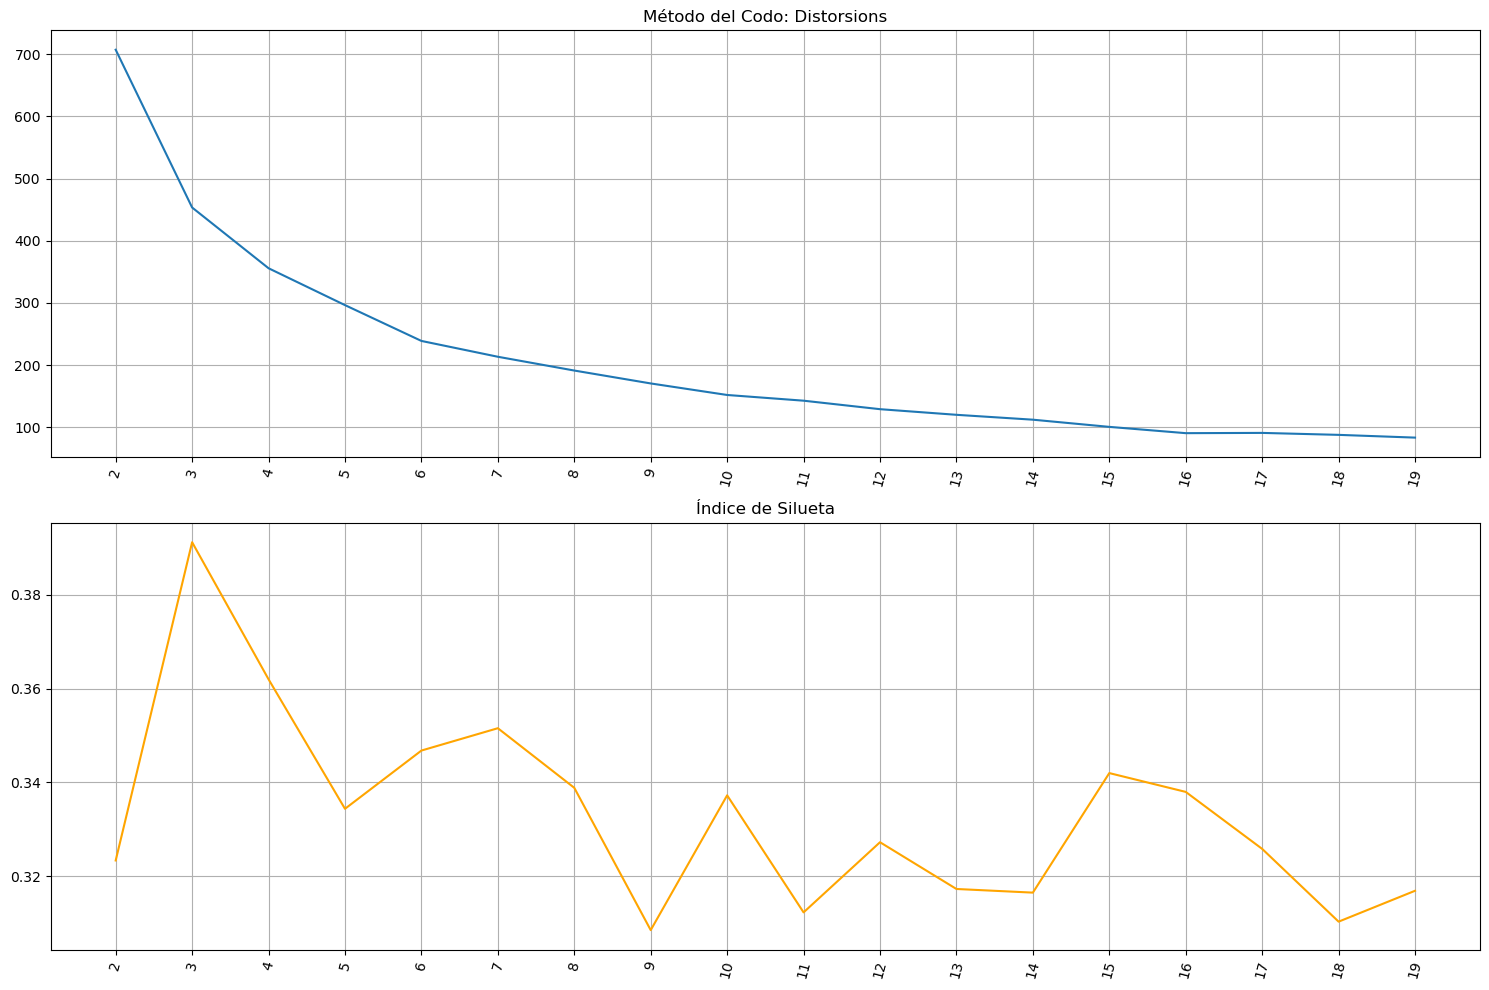

In [10]:
# Visualizar optimización de número de clústers
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot(range(2, max_loop), distorsions, label='Distorsions')
ax[0].set_title('Método del Codo: Distorsions')
ax[0].set_xticks([i for i in range(2, max_loop)])
ax[0].tick_params(axis='x', rotation=75)
ax[0].grid(True)
ax[1].plot(range(2, max_loop), silhouette, label='Silhouette', color='orange')
ax[1].set_title('Índice de Silueta')
ax[1].set_xticks([i for i in range(2, max_loop)])
ax[1].tick_params(axis='x', rotation=75)
ax[1].grid(True)
plt.tight_layout()
plt.show()

In [11]:
# Establecer número de clústers
n_clusters = 6

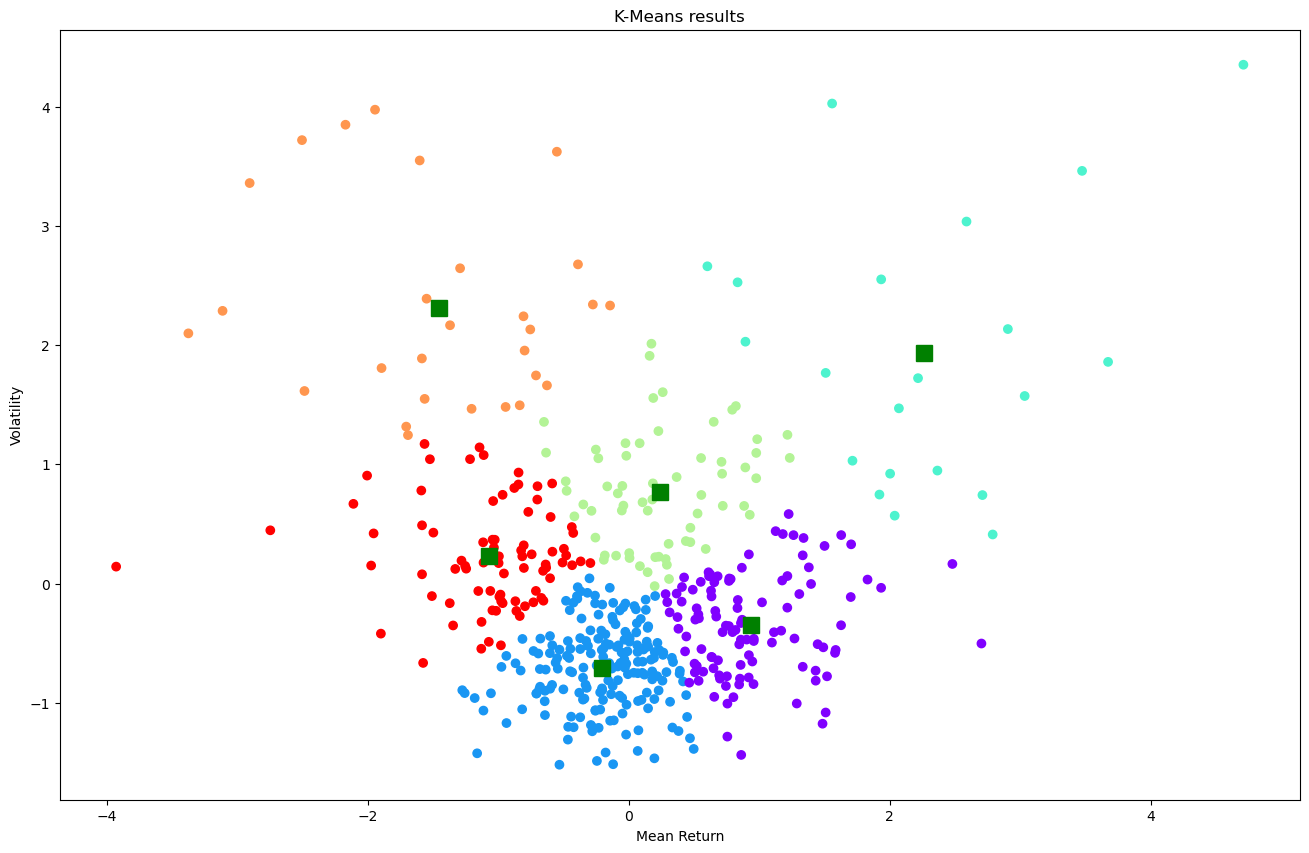

In [12]:
# Entrenar con K-Means
k_means = cluster.KMeans(n_clusters=n_clusters)
# Extrayendo etiquetas
target_labels = k_means.fit_predict(X)
# Visualizando los datos clusterizados
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=k_means.labels_, cmap='rainbow', label=X.index)
ax.set_title('K-Means results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.plot(centroids[:, 0], centroids[:, 1], 'sg', markersize=11)
plt.show()

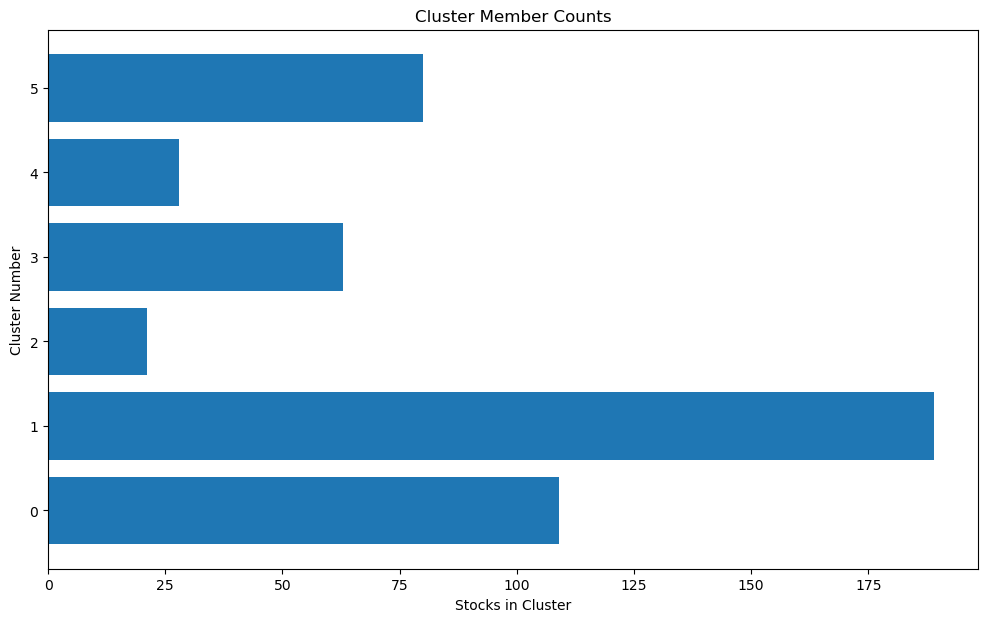

In [13]:
# Mostrar el número de stocks en cada clúster
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
# Gráfico de barras con el número de stocks por clúster
plt.figure(figsize=(12, 7))
plt.barh(
    y=range(len(clustered_series.value_counts())),
    width=clustered_series.value_counts().sort_index()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

### Hierarchical Clustering

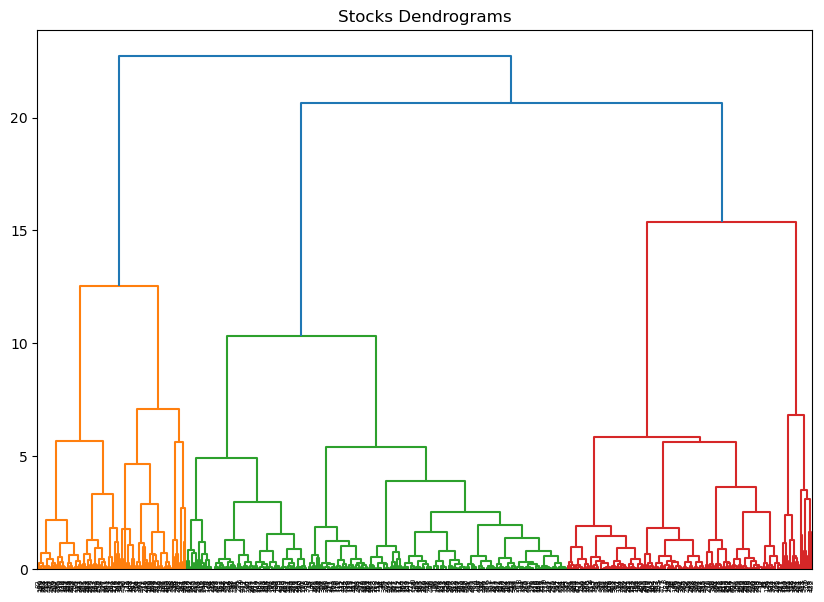

In [14]:
# Hierarchy Clustering (Agglomerative Clustering)
Z = linkage(X, method='ward')
# Plot Dendogram
plt.figure(figsize=(10, 7))
plt.title('Stocks Dendrograms')
dendrogram(Z)
plt.show()

In [15]:
# Situar la altura de la línea que corta en el eje y el número clústers
distance_threshold = 10
clusters = fcluster(Z, distance_threshold, criterion='distance')
chosen_clusters = pd.DataFrame(data=clusters, columns=['cluster'])
n_clusters=len(chosen_clusters['cluster'].unique())
hc = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
clust_labels1 = hc.fit_predict(X)

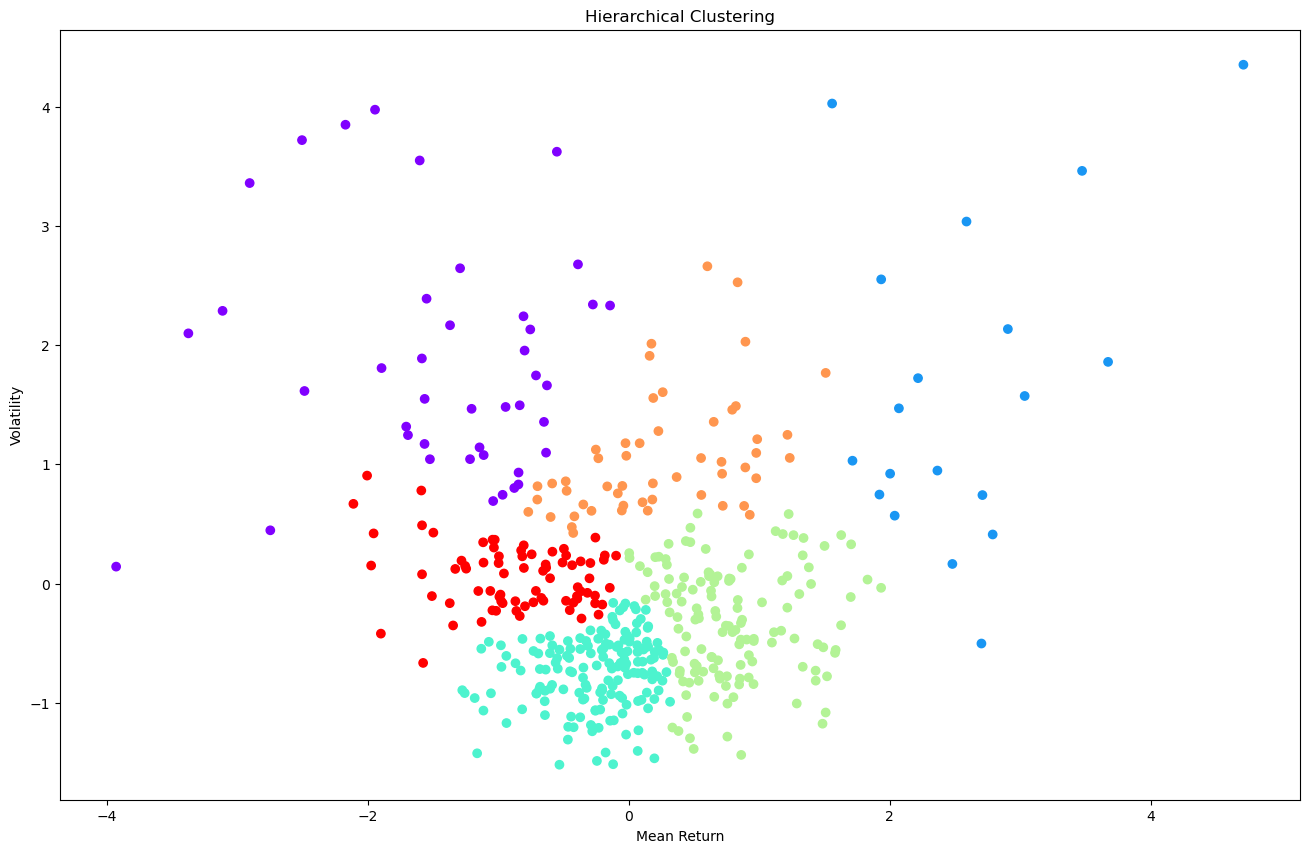

In [16]:
# Visualizar clusterización
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=clust_labels1, cmap='rainbow')
ax.set_title('Hierarchical Clustering')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.show()

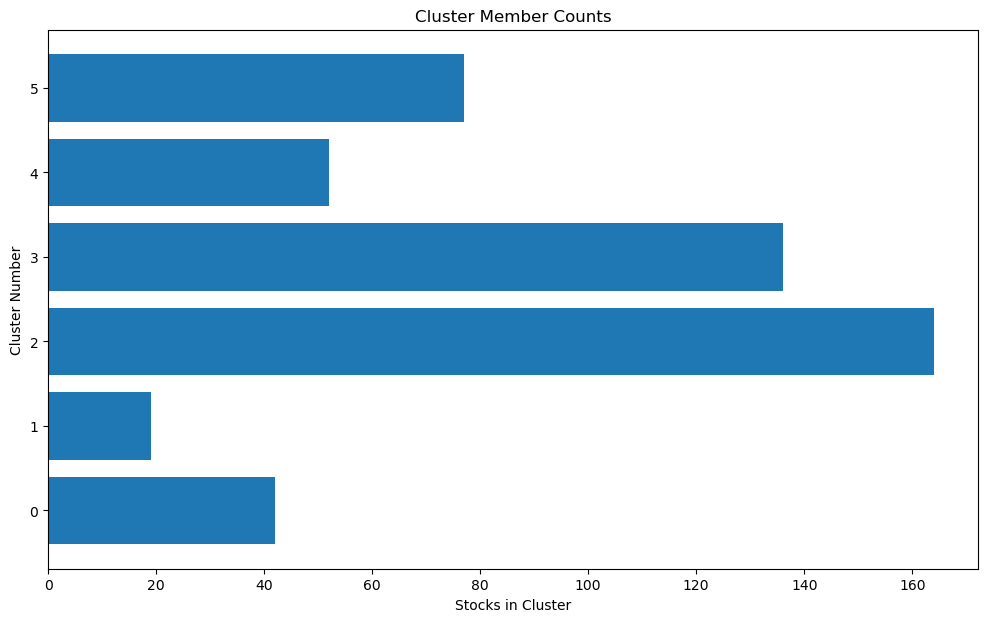

In [17]:
# Mostrar el número de stocks en cada clúster
clustered_series = pd.Series(index=X.index, data=clust_labels1.flatten())
# Gráfico de barras con el número de stocks por clúster
plt.figure(figsize=(12, 7))
plt.barh(
    y=range(len(clustered_series.value_counts())),
    width=clustered_series.value_counts().sort_index()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

### Affinity Propagation

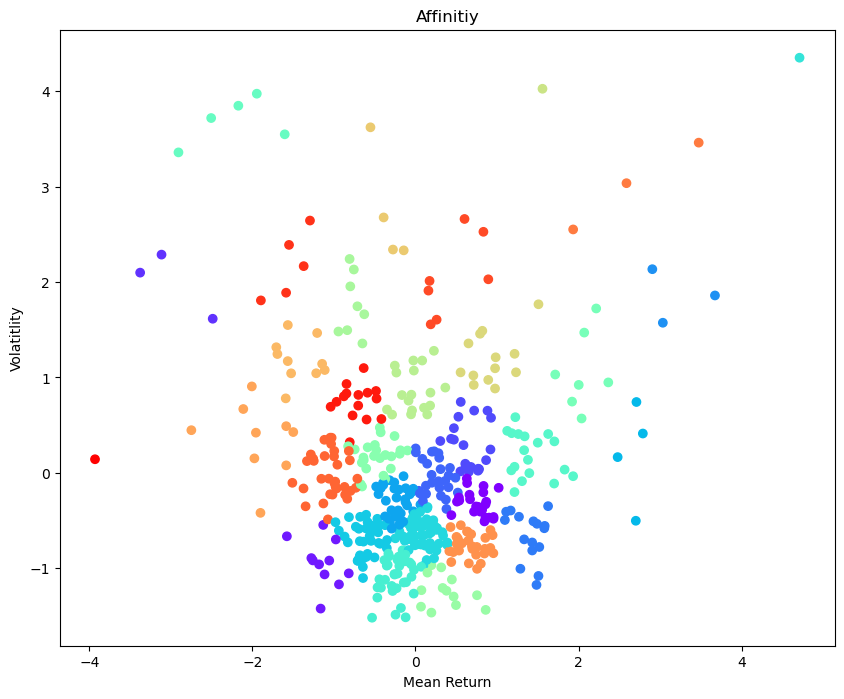

In [18]:
# Affinity Propagation
ap = AffinityPropagation()
ap.fit(X)
clust_labels2 = ap.predict(X)
# Visualizar clústers
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=clust_labels2, cmap='rainbow')
ax.set_title('Affinitiy')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatitlity')
plt.show()

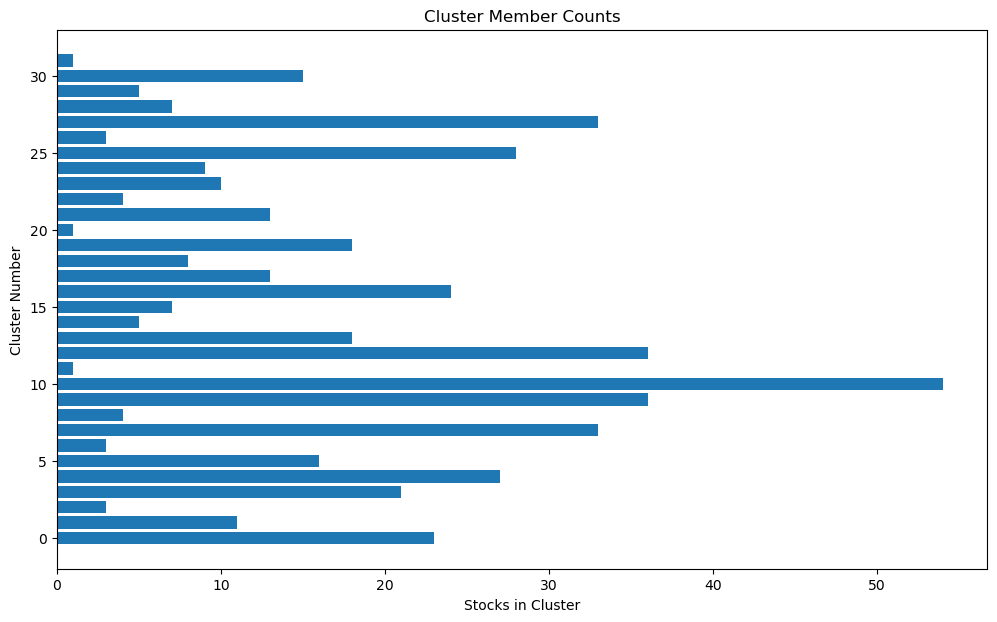

In [19]:
# Mostrar el número de stocks en cada clúster
clustered_series = pd.Series(index=X.index, data=clust_labels2.flatten())
# Gráfico de barras con el número de stocks por clúster
plt.figure(figsize=(12, 7))
plt.barh(
    y=range(len(clustered_series.value_counts())),
    width=clustered_series.value_counts().sort_index()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')
plt.show()

### Cluster Evaluation

In [20]:
print("km", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("hc", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("ap", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

km 0.36267080703531956
hc 0.31835709179361277
ap 0.34888477696648046


In [21]:
# Todos los activos con su etiqueta
clustered_series = pd.Series(index=X.index, data=ap.fit_predict(X).flatten())
clustered_series = clustered_series[clustered_series != -1]
counts = clustered_series.value_counts()
cluster_vis_list = list(counts[(counts<25) & (counts>1)].index)[::-1]

In [22]:
# Número de pares para evaluar
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print("Clusters formed: %d" % len(ticker_count_reduced))
print("Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Clusters formed: 29
Pairs to evaluate: 12298


<Figure size 1200x700 with 0 Axes>

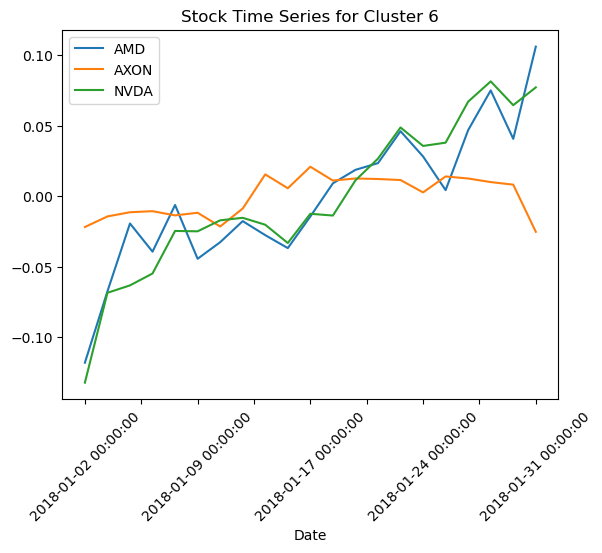

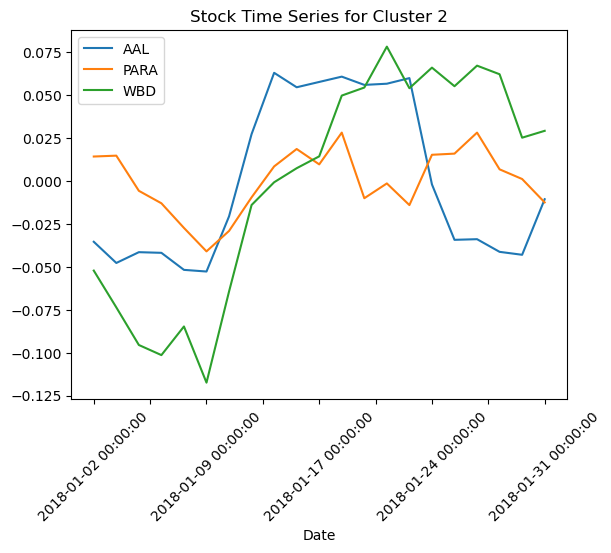

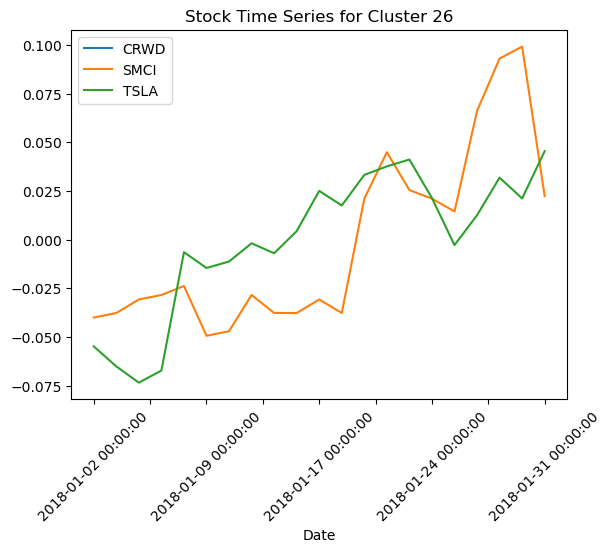

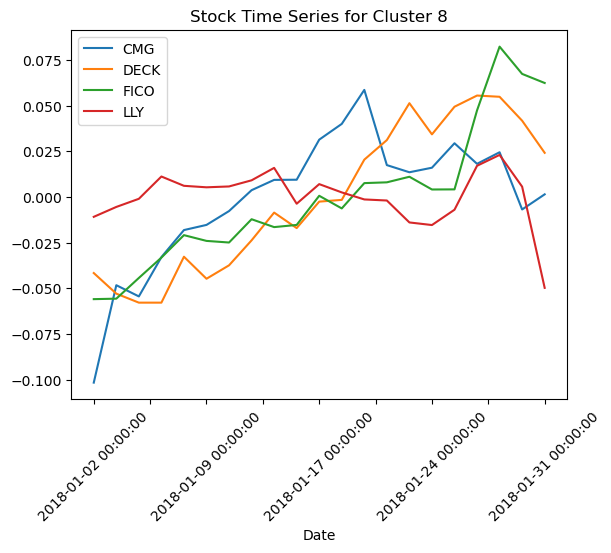

In [23]:
# Visualizar un puñado de clusters pequeños
plt.figure(figsize=(12, 7))
cluster_small_vis = cluster_vis_list[0:min(len(cluster_vis_list), 4)]
for clust in cluster_small_vis:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(df.loc[:"2018-02-01", tickers].mean())
    data = np.log(df.loc[:"2018-02-01", tickers]).sub(means)
    data.plot(title="Stock Time Series for Cluster %d" % clust)
    plt.xticks(rotation=45)
plt.show()


## Cointegration and Pair Selection

In [25]:
def find_cointegrated_pairs(data, significance=0.05):
    n=data.shape[1]
    score_matrix=np.zeros((n, n))
    pvalue_matrix=np.zeros((n, n))
    keys=data.keys()
    pairs=[]
    for i in range(1):
        for j in range(i+1, n):
            S1=data[keys[i]]
            S2=data[keys[j]]
            result=coint(S1, S2)
            score=result[0]
            pvalue=result[1]
            score_matrix[i, j]=score
            pvalue_matrix[i, j]=pvalue
            if pvalue<significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs


In [42]:
cluster_dict={}
df=df.dropna()
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers=clustered_series[clustered_series==which_clust].index
    score_matrix, pvalue_matrix, pairs=find_cointegrated_pairs(df[tickers])
    cluster_dict[which_clust]={}
    cluster_dict[which_clust]['score_matrix']=score_matrix
    cluster_dict[which_clust]['pvalue_matrix']=pvalue_matrix
    cluster_dict[which_clust]['pairs']=pairs

In [43]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [44]:
print(f"Number of pairs found: {len(pairs)}")
print(f"In those pairs, there are {len(np.unique(pairs))} unique tickers.")

Number of pairs found: 21
In those pairs, there are 31 unique tickers.


### Pairs visualization

In [47]:
stocks=np.unique(pairs)
X_df=pd.DataFrame(index=X.index, data=X).T

In [48]:
in_pairs_series=clustered_series.loc[stocks]
stocks=list(np.unique(pairs))
X_pairs=X_df.T.loc[stocks]

In [49]:
X_tsne=TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

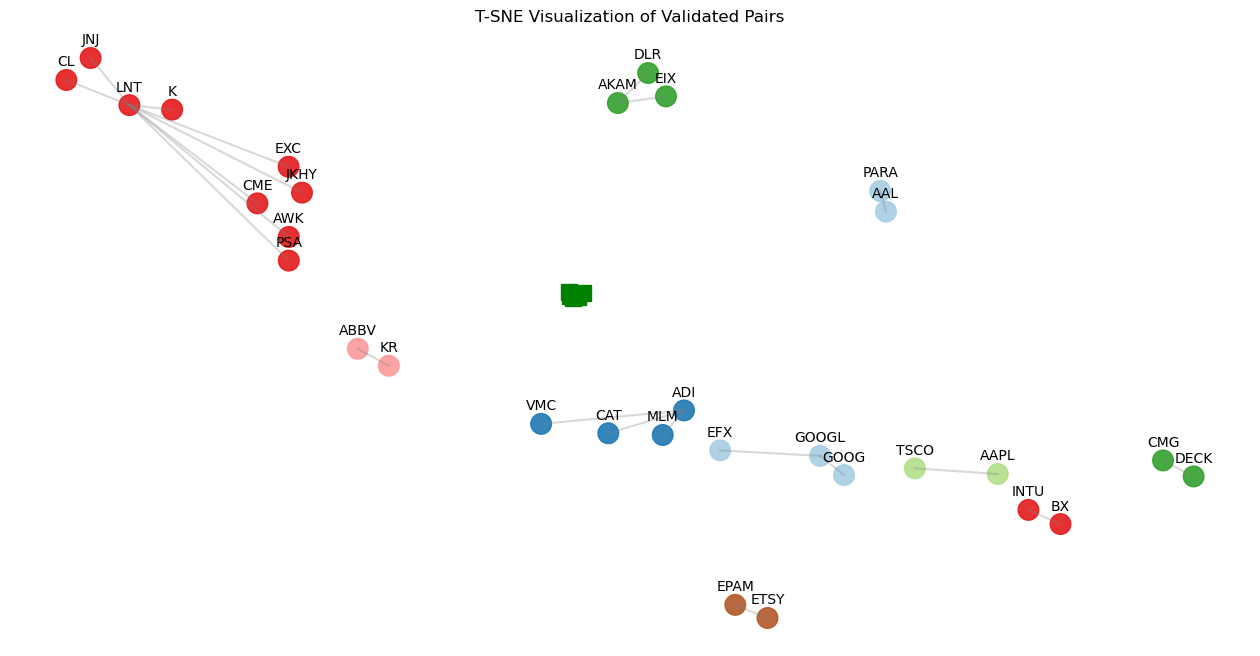

In [51]:
plt.figure(1, facecolor='white', figsize=(16, 8))
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1=pair[0]
    loc1=X_pairs.index.get_loc(pair[0])
    x1, y1=X_tsne[loc1, :]
    ticker2=pair[0]
    loc2=X_pairs.index.get_loc(pair[1])
    x2, y2=X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray')
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('T-SNE Visualization of Validated Pairs')
for x, y, name in zip(X_tsne[:, 0], X_tsne[:, 1], X_pairs.index):
    label=name
    plt.annotate(label, (x, y), textcoords='offset points',
                 xytext=(0, 10), ha='center')
plt.plot(centroids[:, 0], centroids[:, 1], 'sg', markersize=11)
plt.show()